In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
panel_df = pd.read_csv("../data/processed/panel_data.csv")

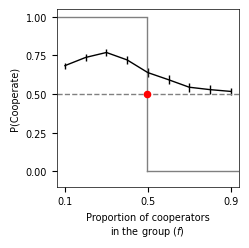

In [4]:
with plt.style.context('nature', 'no-latex'):

    # plot the propbability per round of cooperation
    # plot the 95% confidence interval
    ax = panel_df.groupby('prop_coop')['Decision'].mean().plot(figsize=(2.5, 2.5), yerr=2.576 * panel_df.groupby('prop_coop')['Decision'].sem(), color='black')
    # add horizontal line at 0.5
    plt.axhline(0.5, color='gray', linestyle='--')
    plt.ylim(-0.1, 1.05)
    # add a horizontal line at 1 from 0 to prop_coop 0.5
    plt.axhline(1, xmax=0.495, color='gray', linestyle='-')
    plt.axhline(0, xmin=0.495, color='gray', linestyle='-')
    # add a vertical line at 0.5
    plt.axvline(0.495, ymin=0.09, ymax=.95, color='gray', linestyle='-')
    
    # add black point at 0.5, 0.5 and put in foreground
    plt.scatter(0.495, 0.5, color='red', marker='o', s=20, zorder=2)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticks([0.1, 0.5, 0.9])
    
    plt.ylabel("P(Cooperate)")
    plt.xlabel("Proportion of cooperators\nin the group ($f$)")
    plt.tight_layout()
    plt.savefig("../reports/figures/prop_coop.pdf", bbox_inches='tight')
plt.show()

In [18]:
panel_df['before'] = panel_df['n_cooperators_x'] < 10

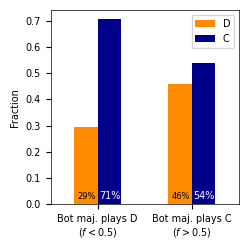

In [141]:
with plt.style.context('nature', 'no-latex'):
    data = (panel_df.groupby(['before', 'Decision']).size() / panel_df.groupby(['before']).size()).unstack()
    data.plot.bar(color=['darkorange', 'darkblue'], figsize=(2.5, 2.5))
    # use "darkorange" and "darkblue" for the colors
    
    # add the percentage of cooperators and defectors taken from the data dataframe to the plot
    frac_defect_before = data.loc[False, 0]
    plt.text(-.22, 0.02, "{:.0f}%".format(frac_defect_before * 100), fontsize=6, color='black')
    frac_defect_before = data.loc[False, 1]
    plt.text(0.02, 0.02, "{:.0f}%".format(frac_defect_before * 100), fontsize=7, color='white')
    
    frac_defect_before = data.loc[True, 0]
    plt.text(1-.22, 0.02, "{:.0f}%".format(frac_defect_before * 100), fontsize=6, color='black')
    frac_defect_before = data.loc[True, 1]
    plt.text(1+0.02, 0.02, "{:.0f}%".format(frac_defect_before * 100), fontsize=7, color='white')


    plt.xticks([0, 1], ["Bot maj. plays D\n($f < 0.5)$", "Bot maj. plays C\n($f > 0.5)$"], rotation=0, fontsize=7)
    plt.xlabel("")
    plt.ylabel("Fraction")
    # rename the Decision column to "Cooperate" and "Defect"
    plt.legend(["D", "C"], loc='upper right')
    # remove box around the legend
    # plt.gca().legend().set_frame_on(False)
    
    
    plt.tight_layout()
    plt.savefig("../reports/figures/prop_coop_before_after.pdf", bbox_inches='tight')
    plt.show()

In [6]:
# compute for each Participant the proportion of times they cooperated before round 6
# and the proportion of times they cooperated after round 6

before = panel_df[panel_df['Round'] < 6].groupby('Participant id')['Decision'].mean()
after = panel_df[panel_df['Round'] > 6].groupby('Participant id')['Decision'].mean()

In [7]:
# add a column to the panel_df with the proportion of times they cooperated before round 6
panel_df['prop_coop_before'] = panel_df['Participant id'].map(before)
panel_df['prop_coop_after'] = panel_df['Participant id'].map(after)

In [8]:
def classify(row):
    if row['prop_coop_before'] < 0.5 and row['prop_coop_after'] > 0.5:
        return "pure herding"
    elif row['prop_coop_before'] > 0.5 and row['prop_coop_after'] < 0.5:
        return "pure rational"
    elif row['prop_coop_before'] < row['prop_coop_after']:
        return "relative herding"
    elif row['prop_coop_before'] > row['prop_coop_after']:
        return "relative rational"
    else:
        return "no change"

In [9]:
panel_df['classification'] = panel_df.apply(classify, axis=1)
panel_df['rel_classification'] = panel_df['classification'].replace({"pure herding": "herding", "pure rational": "rational", "relative herding": "herding", "relative rational": "rational", "no change": "no change"})

In [10]:
# write to file
panel_df.to_csv("../data/processed/panel_data_with_classes.csv")

In [11]:
# count how many participants are in each category
classification_counts = panel_df.groupby('classification')['Participant id'].nunique()
rel_classification_counts = panel_df.groupby('rel_classification')['Participant id'].nunique()

In [12]:
def plot_decision_with_ci(df, ax=None, color='black', label=None):
    df.groupby('prop_coop')['Decision'].mean().plot(yerr=2.576 * df.groupby('prop_coop')['Decision'].sem(), color=color, ax=ax, label=label)

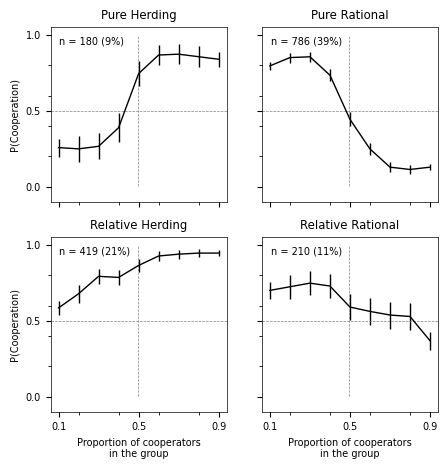

In [13]:
# plot in a grid the evolution of the proportion of cooperation for each classification
with plt.style.context(['nature'], 'no-latex'):
    fig, axs = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)
    for i, classification in enumerate(['pure herding', 'pure rational', 'relative herding', 'relative rational']):
        plot_decision_with_ci(panel_df[panel_df['classification'] == classification], ax=axs[i // 2, i % 2])
        axs[i // 2, i % 2].set_title(classification.title())
        axs[i // 2, i % 2].set_ylim(-0.1, 1.05)
        axs[i // 2, i % 2].axhline(0.5, color='gray', linestyle='--', lw=0.5)
        axs[i // 2, i % 2].axvline(0.495, ymin=0.09, ymax=.95, color='gray', linestyle='--', lw=0.5)
        axs[i // 2, i % 2].set_xlabel("Proportion of cooperators\nin the group")
        axs[i // 2, i % 2].set_ylabel("P(Cooperation)")
        
        # add to the plot the number of participants in each category and percentage in parantheses
        n = classification_counts[classification]
        axs[i // 2, i % 2].text(0.05, 0.95, f"n = {n} ({n / classification_counts.sum() * 100:.0f}%)", transform=axs[i // 2, i % 2].transAxes, verticalalignment='top')
        
        # set ticks at 0, 0.25, 0.5, 0.75, 1
        axs[i // 2, i % 2].set_yticks([0, 0.5, 1])
        axs[i // 2, i % 2].set_xticks([0.1, 0.5, 0.9])
        
    # plt.tight_layout()
    plt.savefig("../reports/figures/prop_coop_by_classification.pdf", bbox_inches='tight')
    plt.show()

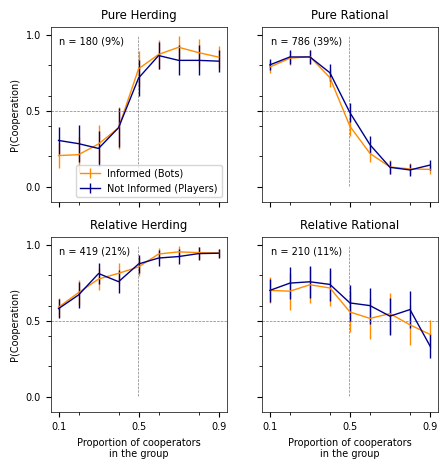

In [14]:
# plot in a grid the evolution of the proportion of cooperation for each classification
with plt.style.context(['nature'], 'no-latex'):
    fig, axs = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)
    for i, classification in enumerate(['pure herding', 'pure rational', 'relative herding', 'relative rational']):
        
        current_ax = axs[i // 2, i % 2]
        panel_bots = panel_df[panel_df['participant.in_deception'] == False]
        panel_humans = panel_df[panel_df['participant.in_deception'] == True]
        
        plot_decision_with_ci(panel_bots[panel_bots['classification'] == classification], ax=current_ax, color='darkorange', label='Informed (Bots)')
        plot_decision_with_ci(panel_humans[panel_humans['classification'] == classification], ax=current_ax, color='darkblue', label='Not Informed (Players)')
        # plot_decision_with_ci(panel_df[panel_df['classification'] == classification], ax=current_ax)
        current_ax.set_title(classification.title())
        current_ax.set_ylim(-0.1, 1.05)
        current_ax.axhline(0.5, color='gray', linestyle='--', lw=0.5)
        current_ax.axvline(0.495, ymin=0.09, ymax=.95, color='gray', linestyle='--', lw=0.5)
        current_ax.set_xlabel("Proportion of cooperators\nin the group")
        current_ax.set_ylabel("P(Cooperation)")
        
        # add to the plot the number of participants in each category and percentage in parantheses
        n = classification_counts[classification]
        current_ax.text(0.05, 0.95, f"n = {n} ({n / classification_counts.sum() * 100:.0f}%)", transform=current_ax.transAxes, verticalalignment='top')
        
        # set ticks at 0, 0.25, 0.5, 0.75, 1
        current_ax.set_yticks([0, 0.5, 1])
        current_ax.set_xticks([0.1, 0.5, 0.9])
        
        # add legend only to the first plot
        if i == 0:
            current_ax.legend()
            # position botton right
            current_ax.legend(loc='lower right')
        
    # plt.tight_layout()
    # add legent for bots and humans
    plt.savefig("../reports/figures/prop_coop_by_classification_with_bots.pdf", bbox_inches='tight')
    plt.show()

In [14]:
# # plot in a grid the evolution of the proportion of cooperation for each classification
# fig, axs = plt.subplots(2, 3, figsize=(10.5, 7), sharex=True, sharey=True)

# classes = [['pure herding', 'cooperating herding', 'defecting herding'], ['pure rational', 'cooperating rational', 'defecting rational']]

# for row in range(2):
#     for col in range(3):
#         classification = classes[row][col]
#         plot_decision_with_ci(panel_df[panel_df['classification'] == classification], ax=axs[row, col])
#         axs[row, col].set_title(classification.title())
#         axs[row, col].set_ylim(-0.1, 1.05)
#         axs[row, col].axhline(0.5, color='gray', linestyle='--')
#         axs[row, col].axvline(0.495, ymin=0.09, ymax=.95, color='gray', linestyle='--')
#         axs[row, col].set_xlabel("Proportion of cooperators\nin the group")
#         axs[row, col].set_ylabel("P(Cooperation)")
        
#         # add to the plot the number of participants in each category and percentage in parantheses
#         n = classification_counts[classification]
#         axs[row, col].text(0.05, 0.01, f"n = {n} ({n / classification_counts.sum() * 100:.0f}%)", transform=axs[row, col].transAxes, verticalalignment='bottom')
        
#         # set ticks at 0, 0.25, 0.5, 0.75, 1
#         axs[row, col].set_yticks([0, 0.5, 1])
#         axs[row, col].set_xticks([0.1, 0.5, 0.9])
        
# plt.tight_layout()
# # plt.savefig("../reports/figures/prop_coop_by_classification.pdf", bbox_inches='tight')
# plt.show()

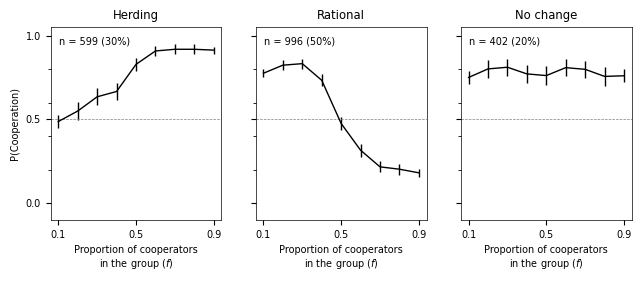

In [110]:
with plt.style.context(['nature'], 'no-latex'):
    fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5), sharex=True, sharey=True)
    for i, classification in enumerate(['herding', 'rational', 'no change']):
        plot_decision_with_ci(panel_df[panel_df['rel_classification'] == classification], ax=axs[i])
        axs[i].set_title(classification.capitalize())
        axs[i].set_ylim(-0.1, 1.05)
        axs[i].axhline(0.5, color='gray', linestyle='--', lw=.5)
        n = rel_classification_counts[classification]
        axs[i].text(0.05, 0.95, f"n = {n} ({n / classification_counts.sum() * 100:.0f}%)", transform=axs[i].transAxes, verticalalignment='top')
        
        axs[i].set_xlabel("Proportion of cooperators\nin the group ($f$)")
        axs[i].set_ylabel("P(Cooperation)")
        
        axs[i].set_yticks([0, 0.5, 1])
        axs[i].set_xticks([0.1, 0.5, 0.9])
        
    # plt.tight_layout()
    plt.savefig("../reports/figures/prop_coop_by_rel_classification.pdf", bbox_inches='tight')
    plt.show()

In [16]:
classification

'no change'

In [17]:
panel_df[panel_df['classification'] == "pure herding"].groupby('prop_coop')['Decision'].mean().iloc[-4:].mean()

0.8583333333333334

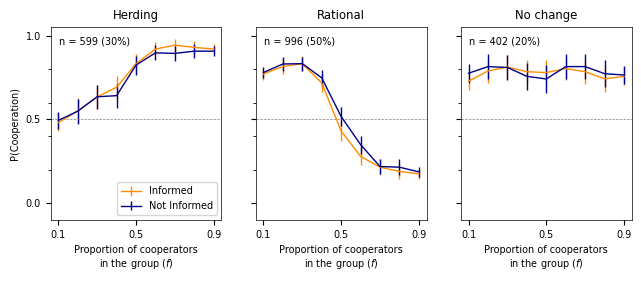

In [109]:
# plot in a grid the evolution of the proportion of cooperation for each relative classification
with plt.style.context(['nature'], 'no-latex'):
    fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5), sharex=True, sharey=True)
    for i, classification in enumerate(['herding', 'rational', 'no change']):
        panel_bots = panel_df[panel_df['participant.in_deception'] == False]
        panel_humans = panel_df[panel_df['participant.in_deception'] == True]
        
        plot_decision_with_ci(panel_bots[panel_bots['rel_classification'] == classification], ax=axs[i], color='darkorange', label='Informed')
        plot_decision_with_ci(panel_humans[panel_humans['rel_classification'] == classification], ax=axs[i], color='darkblue', label='Not Informed')
        axs[i].set_title(classification.capitalize())
        axs[i].set_ylim(-0.1, 1.05)
        axs[i].axhline(0.5, color='gray', linestyle='--', lw=.5)
        n = rel_classification_counts[classification]
        axs[i].text(0.05, 0.95, f"n = {n} ({n / classification_counts.sum() * 100:.0f}%)", transform=axs[i].transAxes, verticalalignment='top')
        
        axs[i].set_xlabel("Proportion of cooperators\nin the group ($f$)")
        axs[i].set_ylabel("P(Cooperation)")
        
        axs[i].set_yticks([0,  0.5, 1])
        axs[i].set_xticks([0.1, 0.5, 0.9])

        if i == 0:
            axs[i].legend()
            # position botton right
            axs[i].legend(loc='lower right')
        
    # plt.tight_layout()
    # plt.savefig("../reports/figures/prop_coop_by_rel_classification.pdf", bbox_inches='tight')
    plt.savefig("../reports/figures/prop_coop_by_rel_classification_with_bots.pdf", bbox_inches='tight')
    plt.show()

In [19]:
def plot_groups(df, groups, classification_counts):
    if len(groups) == 1:
        fig, axs = plt.subplots(1, 1, figsize=(7, 3.5), sharex=True, sharey=True)
        axs = [axs]
    elif len(groups) == 2:
        fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
    elif len(groups) == 4:
        fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
    else:
        raise ValueError("Only 1, 2 or 4 groups are supported")
        plot_decision_with_ci
    
    for i, classification in enumerate(groups):
        plot_decision_with_ci(df[df['classification'] == classification], ax=axs[i])
        axs[i].set_title(classification.title())
        axs[i].set_ylim(-0.1, 1.05)
        axs[i].axhline(0.5, color='gray', linestyle='--', lw=.5)
        axs[i].axvline(0.495, ymin=0.09, ymax=.95, color='gray', linestyle='--', lw=.5)
        axs[i].set_xlabel("Proportion of cooperators\nin the group")
        axs[i].set_ylabel("P(Cooperation)")
        
        # add to the plot the number of participants in each category and percentage in parantheses
        n = classification_counts[classification]
        axs[i].text(0.05, 0.95, f"n = {n} ({n / classification_counts.sum() * 100:.0f}%)", transform=axs[i].transAxes, verticalalignment='top')

In [20]:
def plot_answer_speed(df, classification, ax):
    mean = df[df['classification'] == classification].groupby('Round')['TimeSpent'].mean() / 10
    median = df[df['classification'] == classification].groupby('Round')['TimeSpent'].median() / 10
    
    ax.plot(mean.index, mean, color='black', lw=1.5, label="Mean")
    ax.plot(median.index, median, color='black', lw=1.5, linestyle='--', label="Median")
    

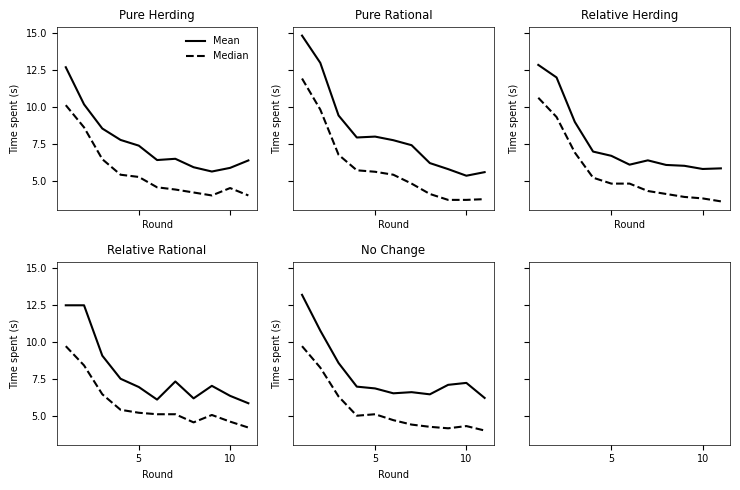

In [21]:
# plot TimeSpent by classification in grid
with plt.style.context('nature', 'no-latex'):
    fig, axs = plt.subplots(2, 3, figsize=(7.5, 5), sharex=True, sharey=True)
    for i, classification in enumerate(['pure herding', 'pure rational', 'relative herding', 'relative rational', 'no change']):
        current_axs = axs[i // 3, i % 3]
        plot_answer_speed(panel_df, classification, current_axs)
        current_axs.set_title(classification.title())
        
        current_axs.set_xlabel("Round")
        current_axs.set_ylabel("Time spent (s)")
        
        if i == 0: # print legend only once
            current_axs.legend(loc='upper right')
            # remove legend bounding box
            current_axs.get_legend().get_frame().set_linewidth(0.0)
            

plt.tight_layout()
plt.savefig("../reports/figures/time_spent_by_classification.pdf", bbox_inches='tight')
plt.show()

In [22]:
panel_df.to_csv("../data/processed/panel_data_classification.csv", index=False)

In [23]:
# count unique participants
panel_df['Participant id'].nunique()

1997

In [24]:
# "debrief.1.player.debrief" is a factor with 3 levels.  # Convert it to a factor
panel_df['debrief_self'] = panel_df['debrief.1.player.debrief'].astype('category')
panel_df['debrief_other'] = panel_df['debrief.1.player.debrief2'].astype('category')

# break down the debriefing by classification
debriefing_counts = panel_df.groupby(['classification', 'debrief_self'])['Participant id'].nunique().unstack()
debriefing_counts = debriefing_counts.reindex(['pure herding', 'pure rational', 'relative herding', 'relative rational'])
debriefing_counts

debrief_self,majority,minority,only_c,only_d,random,sophisticated
classification,,,,,,
pure herding,69,4,42,9,41,15
pure rational,89,240,104,102,98,153
relative herding,57,2,314,10,31,5
relative rational,10,20,101,32,37,10


In [25]:
debriefing_counts = panel_df.groupby(['classification', 'debrief_other'])['Participant id'].nunique().unstack()
debriefing_counts = debriefing_counts.reindex(['pure herding', 'pure rational', 'relative herding', 'relative rational'])

debrieding_pct = debriefing_counts / debriefing_counts.sum().sum() * 100
# add row and column totals
debrieding_pct.loc['Total'] = debrieding_pct.sum()
debrieding_pct['Total'] = debrieding_pct.sum(axis=1)
# round to 1 decimal
debrieding_pct = debrieding_pct.round(1)
debrieding_pct

debrief_other,majority,minority,only_c,only_d,random,sophisticated,Total
classification,,,,,,,
pure herding,4.6,0.3,3.1,0.6,1.8,0.9,11.3
pure rational,21.1,2.4,8.9,3.1,5.7,8.2,49.3
relative herding,7.8,0.7,10.7,1.4,3.5,2.2,26.3
relative rational,3.4,0.4,3.6,1.6,2.6,1.6,13.2
Total,36.9,3.8,26.3,6.6,13.6,12.9,100.0


In [26]:
debriefing_counts_other = panel_df.groupby(['rel_classification', 'debrief_other'])['Participant id'].nunique()
debriefing_counts_self = panel_df.groupby(['rel_classification', 'debrief_self'])['Participant id'].nunique()

# join in one dataframe
debriefing_counts = pd.concat([debriefing_counts_other, debriefing_counts_self], axis=1)
debriefing_counts.columns = ['Other', 'Self']

# debriefing_counts.reset_index(level=1, inplace=True)
# aggregate "sophisticated", "random" and "only_d" into "other" in column "level_1"
# debriefing_counts['level_1'].map({'sophisticated': 'other', 'random': 'other', 'only_d': 'other'},

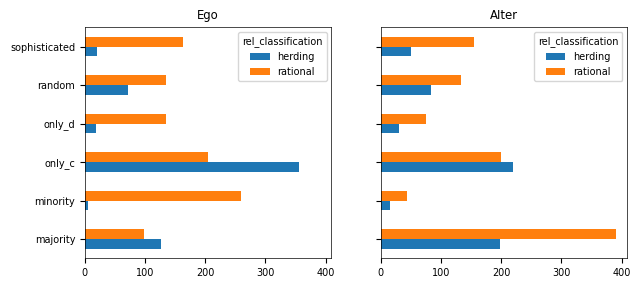

In [27]:
# debriefing_counts.unstack().T.plot.bar(figsize=(6, 4))

with plt.style.context('nature', 'no-latex'):

    # consider only "pure" classifications
    fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

    debriefing_counts = debriefing_counts.loc[['herding', 'rational']]

    # only self
    debriefing_counts['Self'].unstack().T.plot.barh(ax=axs[0])
    axs[0].set_title("Ego")

    debriefing_counts['Other'].unstack().T.plot.barh(ax=axs[1])
    axs[1].set_title("Alter")
    


    plt.show()

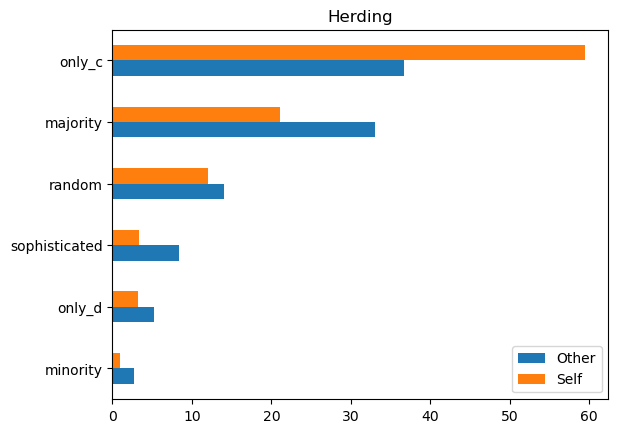

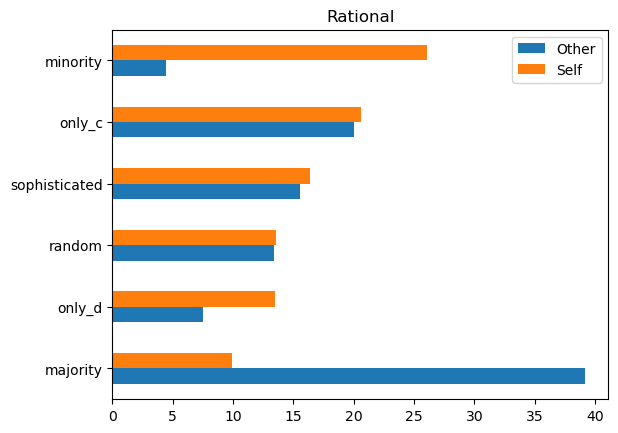

In [28]:
debr_pct = debriefing_counts.loc['herding'] / debriefing_counts.loc['herding'].sum()
(debr_pct * 100).sort_values('Self').plot.barh()
plt.title("Herding")
plt.show()

debr_pct = debriefing_counts.loc['rational'] / debriefing_counts.loc['rational'].sum()
(debr_pct * 100).sort_values('Self').plot.barh()
plt.title("Rational")
# hide legend
plt.show()

In [29]:
df_fixed = pd.read_csv("../data/processed/panel_data_fixed_effects.csv")

In [30]:
df_fixed

,Participant.id,Round,TimeSpent,Decision,bret.1.player.boxes_collected,debrief.1.player.debrief,debrief.1.player.debrief2,Total.approvals,Total.rejections,Approval.rate,...,n_cooperators,prop_coop_before,prop_coop_after,classification,rel_classification,debrief_self,debrief_other,crra,participant_coef,bot_condition
0,5422ae1afdf99b328c91b203,1,34,1,57,majority,random,1624,10,100,...,2,1.0,0.2,pure rational,rational,majority,random,4.074233,0.774233,0
1,5422ae1afdf99b328c91b203,2,46,1,57,majority,random,1624,10,100,...,2,1.0,0.2,pure rational,rational,majority,random,4.074233,0.774233,0
2,5422ae1afdf99b328c91b203,3,33,1,57,majority,random,1624,10,100,...,4,1.0,0.2,pure rational,rational,majority,random,4.074233,0.774233,0
3,5422ae1afdf99b328c91b203,4,148,1,57,majority,random,1624,10,100,...,6,1.0,0.2,pure rational,rational,majority,random,4.074233,0.774233,0
4,5422ae1afdf99b328c91b203,5,21,1,57,majority,random,1624,10,100,...,8,1.0,0.2,pure rational,rational,majority,random,4.074233,0.774233,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,630b0c81cd3699a48aeb88a1,7,13,1,90,minority,majority,1,0,100,...,12,0.8,0.2,pure rational,rational,minority,majority,4.592351,0.683324,1
21963,630b0c81cd3699a48aeb88a1,8,15,0,90,minority,majority,1,0,100,...,14,0.8,0.2,pure rational,rational,minority,majority,4.592351,0.683324,1
21964,630b0c81cd3699a48aeb88a1,9,20,0,90,minority,majority,1,0,100,...,16,0.8,0.2,pure rational,rational,minority,majority,4.592351,0.683324,1
21965,630b0c81cd3699a48aeb88a1,10,8,0,90,minority,majority,1,0,100,...,18,0.8,0.2,pure rational,rational,minority,majority,4.592351,0.683324,1


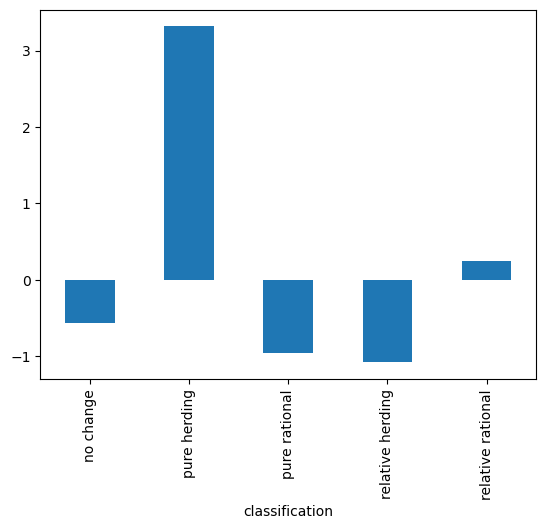

In [31]:
# count boxes collected by classification
(panel_df.groupby('classification')['bret.1.player.boxes_collected'].mean()-50).plot.bar()
plt.show()

In [32]:
def crra(k, max_box=102):
    r = np.log((max_box - k)/ (max_box - 1 - k) / np.log((k+1)/k))
    return r

In [33]:
panel_df['bret.1.player.boxes_collected'].max()

100.0

In [34]:
panel_df['crra'] = panel_df['bret.1.player.boxes_collected'].apply(crra)
panel_df.to_csv("../data/processed/panel_data_classification.csv", index=False)

In [35]:
# get the number of participants in each rel_classification that have answered the different question in debrief_self


def plot_perception_pyramid(perception='debrief_self'):
    debriefing_counts_self = panel_df.query("rel_classification != 'no change'").groupby(['rel_classification', perception])['Participant id'].nunique()
    debriefing_counts_self = debriefing_counts_self.unstack().T
    debriefing_counts_self['total'] = debriefing_counts_self.sum(axis=1)
    debriefing_counts_self = debriefing_counts_self.sort_values('total', ascending=True)
    debriefing_counts_self = debriefing_counts_self / debriefing_counts_self.sum() * 100


    # rename columns
    debriefing_counts_self.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Other", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=0, inplace=True)

    fig, ax = plt.subplots(ncols=2, figsize=(4, 3))
    dbc = debriefing_counts_self.T
    bars_right = dbc.loc['rational']
    bars_left = -dbc.loc['herding']
    bars_left.plot.barh(color='darkorange', ax=ax[0], width=0.7) # Adjusted width
    bars_right.plot.barh(color='darkblue', ax=ax[1], width=0.7) # Adjusted width


    ax[0].set_title("Herding")
    ax[1].set_title("Rational")

    # hide left y axis
    ax[0].get_yaxis().set_visible(False)

    # remove y label
    ax[1].set_ylabel("")
    # center the y tick labels
    ax[1].set_yticklabels(ax[1].get_yticklabels(), ha='center', fontsize=8.5)
    # shift the y tick labels to the left
    ax[1].tick_params(axis='y', pad=35)

    # increase space between subplots
    plt.subplots_adjust(wspace=0.95)


    # remove spines
    for a in ax:
        a.spines['right'].set_visible(False)
        # a.spines['top'].set_visible(False)
        a.spines['left'].set_visible(False)
        # a.spines['bottom'].set_visible(False)

        a.tick_params(axis='both', which='both', length=0)
        for i, p in enumerate(a.patches):
            width = p.get_width()
            if a == ax[0]:
                a.annotate('{:.0f}%'.format(abs(width)), (width - 20, p.get_y() + 0.15))
            else:
                a.annotate('{:.0f}%'.format(abs(width)), (width + 1, p.get_y() + 0.15))
    
    # add a bit of space on the left and to the left plot
    # get min value of the left plot
    min_val = min([p.get_width() for p in ax[0].patches])
    ax[0].set_xlim(min_val - 20, 0)
    # set the x axis labels of the left plot to their absolute values
    ax[0].set_xticklabels([str(abs(int(x))) for x in ax[0].get_xticks()])

/var/folders/6k/5hmkfvg15c96n_sg9wvgtgzm0000gn/T/ipykernel_8885/376252841.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(abs(int(x))) for x in ax[0].get_xticks()])


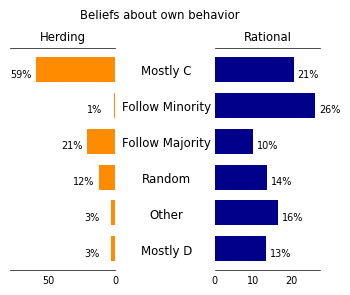

In [36]:
with plt.style.context('nature', 'no-latex'):
    plot_perception_pyramid('debrief_self')
    plt.suptitle("Beliefs about own behavior")
    plt.subplots_adjust(top=0.85)
    plt.savefig("../reports/figures/perception_pyramid_self.pdf", bbox_inches='tight')
    plt.show()

/var/folders/6k/5hmkfvg15c96n_sg9wvgtgzm0000gn/T/ipykernel_8885/376252841.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(abs(int(x))) for x in ax[0].get_xticks()])


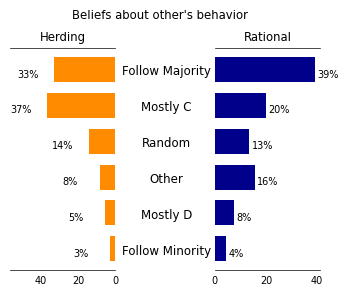

In [37]:
with plt.style.context('nature', 'no-latex'):
    plot_perception_pyramid('debrief_other')
    plt.suptitle("Beliefs about other's behavior")
    plt.subplots_adjust(top=0.85)
    plt.savefig("../reports/figures/perception_pyramid_other.pdf", bbox_inches='tight')
    plt.show()

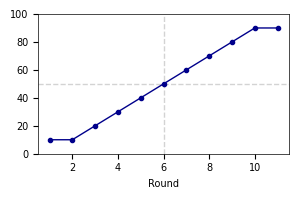

In [38]:
with plt.style.context('nature', 'no-latex'):
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.axhline(50, color='lightgray', linestyle='--', lw=1)
    ax.axvline(6, color='lightgray', linestyle='--', lw=1)
    prop_round = panel_df[['Round', 'prop_coop']].drop_duplicates()
    prop_round['prop_coop'] = prop_round['prop_coop'] * 100
    prop_round.plot(x='Round', y='prop_coop', marker='o', color='darkblue', ax=ax)
    # hide legend
    plt.gca().legend_.remove()
    plt.xlabel("Round")
    # plt.title("Percentage of bots playing C")
    # add horizontal line at 50%

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig("../reports/figures/bot_coop_by_round.pdf", bbox_inches='tight')
    plt.show()

In [55]:
debriefing_counts_self = panel_df.groupby(['classification', "debrief_other"])['Participant id'].nunique()
debriefing_counts_self = debriefing_counts_self.unstack().T
debriefing_counts_self['total'] = debriefing_counts_self.sum(axis=1)
debriefing_counts_self = debriefing_counts_self.sort_values('total', ascending=True)
debriefing_counts_self = debriefing_counts_self / debriefing_counts_self.sum() * 100
debriefing_counts_self.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Other", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=0, inplace=True)

print(debriefing_counts_self.round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
classification &  no change &  pure herding &  pure rational &  relative herding &  relative rational &  total \\
debrief\_other   &            &               &                &                   &                    &        \\
\midrule
Follow Minority &       2.49 &          2.78 &           4.83 &              2.63 &               2.86 &   3.51 \\
Mostly D        &       7.71 &          5.00 &           6.23 &              5.25 &              12.38 &   6.86 \\
Other           &      15.67 &          8.33 &          16.54 &              8.35 &              11.90 &  13.42 \\
Random          &      23.63 &         15.56 &          11.58 &             13.37 &              20.00 &  15.62 \\
Mostly C        &      25.62 &         27.22 &          18.07 &             40.81 &              27.14 &  26.14 \\
Follow Majority &      24.88 &         41.11 &          42.75 &             29.59 &              25.71 &  34.45 \\
\bottomrule
\end{tabular}



/var/folders/6k/5hmkfvg15c96n_sg9wvgtgzm0000gn/T/ipykernel_8885/3499086042.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(debriefing_counts_self.round(2).to_latex())


In [56]:
debriefing_counts_self = panel_df.groupby(['rel_classification', "debrief_other"])['Participant id'].nunique()
debriefing_counts_self = debriefing_counts_self.unstack().T
debriefing_counts_self['total'] = debriefing_counts_self.sum(axis=1)
debriefing_counts_self = debriefing_counts_self.sort_values('total', ascending=True)
debriefing_counts_self = debriefing_counts_self / debriefing_counts_self.sum() * 100
debriefing_counts_self.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Other", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=0, inplace=True)

print(debriefing_counts_self.round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
rel\_classification &  herding &  no change &  rational &  total \\
debrief\_other   &          &            &           &        \\
\midrule
Follow Minority &     2.67 &       2.49 &      4.42 &   3.51 \\
Mostly D        &     5.18 &       7.71 &      7.53 &   6.86 \\
Other           &     8.35 &      15.67 &     15.56 &  13.42 \\
Random          &    14.02 &      23.63 &     13.35 &  15.62 \\
Mostly C        &    36.73 &      25.62 &     19.98 &  26.14 \\
Follow Majority &    33.06 &      24.88 &     39.16 &  34.45 \\
\bottomrule
\end{tabular}



/var/folders/6k/5hmkfvg15c96n_sg9wvgtgzm0000gn/T/ipykernel_8885/1652601665.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(debriefing_counts_self.round(2).to_latex())


In [57]:
panel_df['TimeSpent'] = panel_df['TimeSpent'] / 10

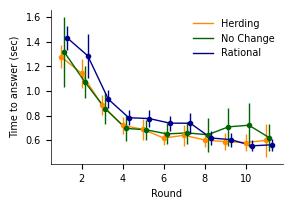

In [58]:
# group by proportion of C and rel_classification and plot the time answer
time_to_answer_grou_mean = panel_df.groupby(['rel_classification', 'Round'])['TimeSpent'].mean().unstack().T
time_to_answer_grou_std = panel_df.groupby(['rel_classification', 'Round'])['TimeSpent'].std().unstack().T 
time_to_answer_grou_sqrtn = np.sqrt(panel_df.groupby(['rel_classification', 'Round'])['TimeSpent'].size().unstack().T)
time_to_answer_grou_std = time_to_answer_grou_std / time_to_answer_grou_sqrtn * 2.57583

# plot mean with error bars
with plt.style.context('nature', 'no-latex'):
    fig, ax = plt.subplots(figsize=(3, 2))
    
    # add error bars
    colors = ['darkorange', 'darkgreen', 'darkblue']
    classes = time_to_answer_grou_mean.columns
    for i, col in enumerate(classes):
        ax.plot(time_to_answer_grou_mean.index+0.15*i, time_to_answer_grou_mean[col], color=colors[i])
        ax.errorbar(time_to_answer_grou_mean.index+0.15*i, time_to_answer_grou_mean[col], yerr=time_to_answer_grou_std[col], fmt='o', color=colors[i])
    plt.xlabel("Round")
    plt.ylabel("Time to answer (sec)")
    
    # legend
    plt.legend([c.title() for c in classes], loc='upper right', frameon=False)
    plt.savefig("../reports/figures/time_to_answer.pdf", bbox_inches='tight')
    # remove top and right spines using plt
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

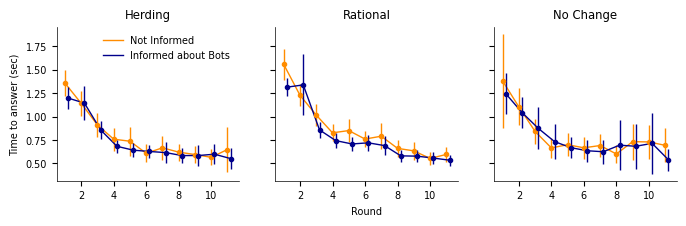

In [59]:
# group by proportion of C and rel_classification and plot the time answer
time_to_answer_grou_mean = panel_df.groupby(['rel_classification', 'participant.in_deception', 'Round'])['TimeSpent'].mean().unstack().T
time_to_answer_grou_std = panel_df.groupby(['rel_classification', 'participant.in_deception', 'Round'])['TimeSpent'].std().unstack().T 
time_to_answer_grou_sqrtn = np.sqrt(panel_df.groupby(['rel_classification', 'participant.in_deception', 'Round'])['TimeSpent'].size().unstack().T)

time_to_answer_grou_std = time_to_answer_grou_std / time_to_answer_grou_sqrtn * 2.57583 # 95% confidence interval


# plot mean with error bars
with plt.style.context('nature', 'no-latex'):
    fig, ax = plt.subplots(ncols=3, figsize=(8, 2), sharex=True, sharey=True)

    classes = ['herding', 'rational', 'no change']
    colors = ['darkorange', 'darkblue']
    for i, col in enumerate(classes):
        ax[i].plot(time_to_answer_grou_mean.index, time_to_answer_grou_mean[col][0], color=colors[0])
        ax[i].errorbar(time_to_answer_grou_mean.index, time_to_answer_grou_mean[col][0], yerr=time_to_answer_grou_std[col][0], fmt='o', color=colors[0])

        ax[i].plot(time_to_answer_grou_mean.index+.2, time_to_answer_grou_mean[col][1], color=colors[1])
        ax[i].errorbar(time_to_answer_grou_mean.index+.2, time_to_answer_grou_mean[col][1], yerr=time_to_answer_grou_std[col][1], fmt='o', color=colors[1])
        ax[i].set_title(col.title())

        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)    
    ax[0].set_ylabel("Time to answer (sec)")
    ax[1].set_xlabel("Round")
    # ax[0].set_ylim(0, 30)
    # ax.ylabel("Time to answer (sec)")
    
    # legend
    ax[0].legend(["Not Informed", "Informed about Bots"], loc='upper right', frameon=False)
    plt.savefig("../reports/figures/time_to_answer_deception.pdf", bbox_inches='tight')
    # remove top and right spines using plt

    plt.show()

In [60]:
time_to_answer_grou_mean = panel_df.groupby(['rel_classification', 'participant.in_deception', 'Round'])['TimeSpent'].mean().unstack().T

In [61]:
# get the number of participants in each rel_classification that have answered the different question in debrief_self


def plot_perception_pyramid(perception='debrief_self'):
    debriefing_counts_self = panel_df.query("rel_classification != 'no change'").groupby(['rel_classification', perception])['Participant id'].nunique()
    debriefing_counts_self = debriefing_counts_self.unstack().T
    debriefing_counts_self['total'] = debriefing_counts_self.sum(axis=1)
    debriefing_counts_self = debriefing_counts_self.sort_values('total', ascending=True)
    debriefing_counts_self = debriefing_counts_self / debriefing_counts_self.sum() * 100


    # rename columns
    debriefing_counts_self.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Sophisticated", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=0, inplace=True)

    fig, ax = plt.subplots(ncols=2, figsize=(4, 3))
    dbc = debriefing_counts_self.T
    bars_right = dbc.loc['rational']
    bars_left = -dbc.loc['herding']
    bars_left.plot.barh(color='darkorange', ax=ax[0], width=0.7) # Adjusted width
    bars_right.plot.barh(color='darkblue', ax=ax[1], width=0.7) # Adjusted width


    ax[0].set_title("Herding")
    ax[1].set_title("Rational")

    # hide left y axis
    ax[0].get_yaxis().set_visible(False)

    # remove y label
    ax[1].set_ylabel("")
    # center the y tick labels
    ax[1].set_yticklabels(ax[1].get_yticklabels(), ha='center', fontsize=8.5)
    # shift the y tick labels to the left
    ax[1].tick_params(axis='y', pad=35)

    # increase space between subplots
    plt.subplots_adjust(wspace=0.95)


    # remove spines
    for a in ax:
        a.spines['right'].set_visible(False)
        # a.spines['top'].set_visible(False)
        a.spines['left'].set_visible(False)
        # a.spines['bottom'].set_visible(False)

        a.tick_params(axis='both', which='both', length=0)
        for i, p in enumerate(a.patches):
            width = p.get_width()
            if a == ax[0]:
                a.annotate('{:.0f}%'.format(abs(width)), (width - 20, p.get_y() + 0.15))
            else:
                a.annotate('{:.0f}%'.format(abs(width)), (width + 1, p.get_y() + 0.15))
    
    # add a bit of space on the left and to the left plot
    # get min value of the left plot
    min_val = min([p.get_width() for p in ax[0].patches])
    ax[0].set_xlim(min_val - 20, 0)
    # set the x axis labels of the left plot to their absolute values
    ax[0].set_xticklabels([str(abs(int(x))) for x in ax[0].get_xticks()])

In [62]:
# rename the column participant.in_deception to 'informed' and convert 0 to True and 1 to False
panel_df['informed'] = panel_df['participant.in_deception'].apply(lambda x: "Yes" if x == 0 else "No")

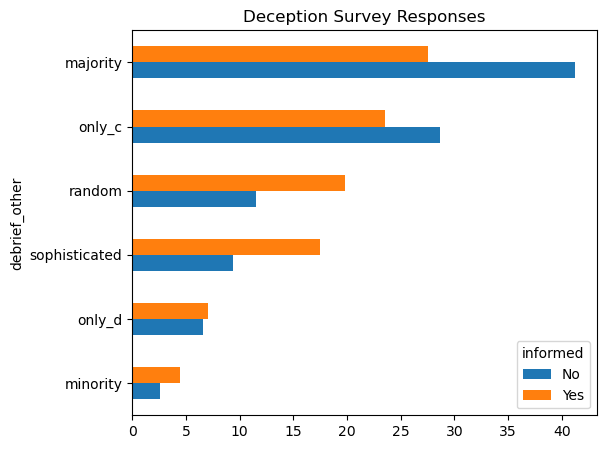

In [63]:
# deception_survey_counts = panel_df.query("rel_classification == 'herding'").groupby(["debrief_other", 'participant.in_deception'])['Participant id'].nunique().unstack()
deception_survey_counts = panel_df.groupby(["debrief_other", 'informed'])['Participant id'].nunique().unstack()


deception_survey_mean  = (deception_survey_counts  / deception_survey_counts.sum(0)) * 100

deception_survey_mean.sort_values("Yes").plot(kind='barh', figsize=(6, 5), title='Deception Survey Responses')
plt.show()

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import fisher_exact



def plot_believes_by_informed_status_change(df, who='debrief_other', show_y_labels=True, ax=None):
    df_counts = df.groupby(['informed', who])['Participant id'].nunique().unstack(fill_value=0)
    print(df_counts)
    
    # reverse order of columns
    df_counts = df_counts.iloc[:, ::-1]
    
    # Calculate the percentages
    df_percentages = df_counts.div(df_counts.sum(axis=1), axis=0) * 100
    df_percentages.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Other", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=1, inplace=True)
    
    # Perform Fisher's exact test and store p-values
    p_values = []
    
    for col in df_counts.columns:
        # Create a 2x2 table for this category and the rest
        table = [[df_counts.loc['Yes', col], df_counts.loc['No', col]],
                [df_counts.loc['Yes'].sum() - df_counts.loc['Yes', col], df_counts.loc['No'].sum() - df_counts.loc['No', col]]]

        # Perform Fisher's Exact Test
        _, pvalue = fisher_exact(table)
        p_values.append(pvalue)
        
    # apply Bonferroni correction
    p_values = [min(p * len(p_values), 1.) for p in p_values]

    
    
    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3.5))

    # Plot the percentages
    
    change = df_percentages.loc['Yes'] - df_percentages.loc['No']
    x = np.arange(len(df_percentages.columns))
    
    if show_y_labels:    
        ax.set_yticks(x)
        ax.set_yticklabels(df_percentages.columns)  # 'ha' parameter is set to 'right'
    else:
        ax.set_yticks([])

    
    # ax.barh(x + 0.2, df_percentages.loc['Yes'], height=0.4, color='darkorange', align='center', label='Yes')
    # ax.barh(x - 0.2, df_percentages.loc['No'], height=0.4, color='gray', align='center', label='No')
    
    ax.barh(x, change, height=0.3, color='darkorange', align='center', label='Yes')
    
    # # Annotate bars with the p-values
    for i, p_value in enumerate(p_values):
        if change[i] < 0:
            ax.text(-.3, i+.3, f'p={p_value:.3g}', ha='right', fontdict={'fontsize': 5, "fontstyle": "italic"})
            ax.text(change[i]-.5, i-.1, f'{change[i]:+.1f}%', ha='right', fontdict={'fontsize': 8})
        else:
            ax.text(.3, i+.3, f'p={p_value:.3g}', ha='left', fontdict={'fontsize': 5,  "fontstyle": "italic"})
            ax.text(change[i]+.5, i-.1, f'{change[i]:+.1f}%', ha='left', fontdict={'fontsize': 8})


    # Formatting the plot
    # ax.set_xlabel('Category')

    # ax.legend(title='Informed\nabout bots')
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

    ax.set_xlim(-24, 15.5)
    ax.set_ylim(-.5, 5.5)
    
    # remove y ticks
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(top=False, which='both')
    
    # add vertical line at 0
    ax.axvline(0, color='gray', linewidth=0.5)

    # Show the plot
    # plt.tight_layout()  # adjust layout to avoid overlapping
    # plt.show()


debrief_self  majority  minority  only_c  only_d  random  sophisticated
informed                                                               
No                  89       171     417      93     130            109
Yes                157       108     411      81     136             95
debrief_self  majority  minority  only_c  only_d  random  sophisticated
informed                                                               
No                  21       157     113      72      61             95
Yes                 78       103      92      62      74             68
debrief_self  majority  minority  only_c  only_d  random  sophisticated
informed                                                               
No                  62         5     174      11      41              8
Yes                 64         1     182       8      31             12
debrief_other  majority  minority  only_c  only_d  random  sophisticated
informed                                                       

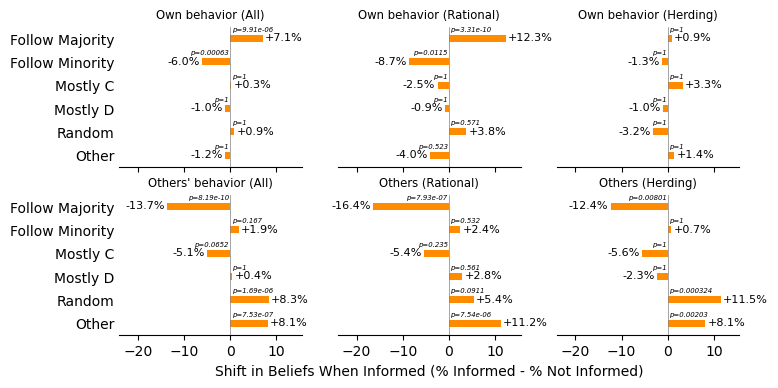

In [69]:
# create a 3 x 2 plot of the evolution of the herding model
fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

with plt.style.context(["science", "nature", "no-latex"]):
    plot_believes_by_informed_status_change(panel_df, 'debrief_self', show_y_labels=True, ax=ax[0][0])
    ax[0][0].set_title('Own behavior (All)')
    
    
    plot_believes_by_informed_status_change(panel_df.query("rel_classification == 'rational'"), 'debrief_self', show_y_labels=True, ax=ax[0][1])
    ax[0][1].set_title('Own behavior (Rational)')
    
    plot_believes_by_informed_status_change(panel_df.query("rel_classification == 'herding'"), 'debrief_self', show_y_labels=True, ax=ax[0][2])
    ax[0][2].set_title('Own behavior (Herding)')


    plot_believes_by_informed_status_change(panel_df, 'debrief_other', show_y_labels=True, ax=ax[1][0])
    ax[1][0].set_title('Others\' behavior (All)')
    # ax[1][0].set_xlabel('%Informed - %Not Informed')
    
    plot_believes_by_informed_status_change(panel_df.query("rel_classification == 'rational'"), 'debrief_other', show_y_labels=True, ax=ax[1][1])
    ax[1][1].set_title('Others (Rational)')
    ax[1][1].set_xlabel("Shift in Beliefs When Informed (% Informed - % Not Informed)")
    
    plot_believes_by_informed_status_change(panel_df.query("rel_classification == 'herding'"), 'debrief_other', show_y_labels=True, ax=ax[1][2])
    ax[1][2].set_title('Others (Herding)')
    # ax[1][2].set_xlabel('%Informed - %Not Informed')

plt.savefig('../reports/figures/believe_shift_all.pdf', bbox_inches='tight')
# plt.tight_layout()
plt.show()

In [ ]:
def plot_believes_by_informed_status(df, who='debrief_other', show_y_labels=True, ax=None):
    df_counts = df.groupby(['informed', who])['Participant id'].nunique().unstack(fill_value=0)
    print(df_counts)
    
    # reverse order of columns
    df_counts = df_counts.iloc[:, ::-1]
    
    # Calculate the percentages
    df_percentages = df_counts.div(df_counts.sum(axis=1), axis=0) * 100
    df_percentages.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Other", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=1, inplace=True)
    
    # Perform Fisher's exact test and store p-values
    p_values = []
    
    for col in df_counts.columns:
        # Create a 2x2 table for this category and the rest
        table = [[df_counts.loc['Yes', col], df_counts.loc['No', col]],
                [df_counts.loc['Yes'].sum() - df_counts.loc['Yes', col], df_counts.loc['No'].sum() - df_counts.loc['No', col]]]

        # Perform Fisher's Exact Test
        _, pvalue = fisher_exact(table)
        p_values.append(pvalue)
        
    # apply Bonferroni correction
    p_values = [min(p * len(p_values), 1.) for p in p_values]

    
    
    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3.5))

    # Plot the percentages
    
    change = df_percentages.loc['Yes'] - df_percentages.loc['No']
    x = np.arange(len(df_percentages.columns))
    
    if show_y_labels:    
        ax.set_yticks(x)
        ax.set_yticklabels(df_percentages.columns)  # 'ha' parameter is set to 'right'
    else:
        ax.set_yticks([])

    
    # ax.barh(x + 0.2, df_percentages.loc['Yes'], height=0.4, color='darkorange', align='center', label='Yes')
    # ax.barh(x - 0.2, df_percentages.loc['No'], height=0.4, color='gray', align='center', label='No')
    
    ax.barh(x, change, height=0.3, color='darkorange', align='center', label='Yes')
    
    # # Annotate bars with the p-values
    for i, p_value in enumerate(p_values):
        if change[i] < 0:
            ax.text(-.3, i+.3, f'p={p_value:.3g}', ha='right', fontdict={'fontsize': 5, "fontstyle": "italic"})
            ax.text(change[i]-.5, i-.1, f'{change[i]:+.1f}%', ha='right', fontdict={'fontsize': 8})
        else:
            ax.text(.3, i+.3, f'p={p_value:.3g}', ha='left', fontdict={'fontsize': 5,  "fontstyle": "italic"})
            ax.text(change[i]+.5, i-.1, f'{change[i]:+.1f}%', ha='left', fontdict={'fontsize': 8})


    # Formatting the plot
    # ax.set_xlabel('Category')

    # ax.legend(title='Informed\nabout bots')
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

    ax.set_xlim(-24, 15.5)
    ax.set_ylim(-.5, 5.5)
    
    # remove y ticks
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(top=False, which='both')
    
    # add vertical line at 0
    ax.axvline(0, color='gray', linewidth=0.5)

    # Show the plot
    # plt.tight_layout()  # adjust layout to avoid overlapping
    # plt.show()


In [104]:
def plot_beliefs_by_informed_status_ASD(df, who='debrief_other', show_y_labels=True, ax=None):
    df_counts = df.groupby(['informed', who])['Participant id'].nunique().unstack(fill_value=0)
    
    # reverse order of columns
    df_counts = df_counts.iloc[:, ::-1]
    
    # Calculate the percentages
    df_percentages = df_counts.div(df_counts.sum(axis=1), axis=0) * 100
    df_percentages.rename({"only_c": "Mostly C", "only_d": "Mostly D", "random": "Random", "sophisticated": "Other", "majority": "Follow Majority", "minority": "Follow Minority"}, axis=1, inplace=True)

    
    x = np.arange(len(df_percentages.columns))
    
    if show_y_labels:
        ax.set_yticks(x)
        ax.set_yticklabels(df_percentages.columns)
    else:
        ax.set_yticks([])

    ax.barh(x + 0.2, df_percentages.loc['Yes'], height=0.4, color='darkorange', align='center', label='Informed')
    ax.barh(x - 0.2, df_percentages.loc['No'], height=0.4, color='gray', align='center', label='Not Informed')
    
    # Formatting the plot
    # ax.set_xlim(0, max(df_percentages.max()) + 10)  # Adjust the x-limit based on your data
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add percentage labels on the right of the bars
    for i, value in enumerate(df_percentages.loc['Yes']):
        ax.text(value + 1, i + 0.2, f"{value:.2f}%", va='center', ha='left', fontsize=5)
    
    for i, value in enumerate(df_percentages.loc['No']):
        ax.text(value + 1, i - 0.2, f"{value:.1f}%", va='center', ha='left', fontsize=5)

    
    # remove y ticks
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(top=False, which='both')

    # plt.tight_layout()  # adjust layout to avoid overlapping
    # plt.show()


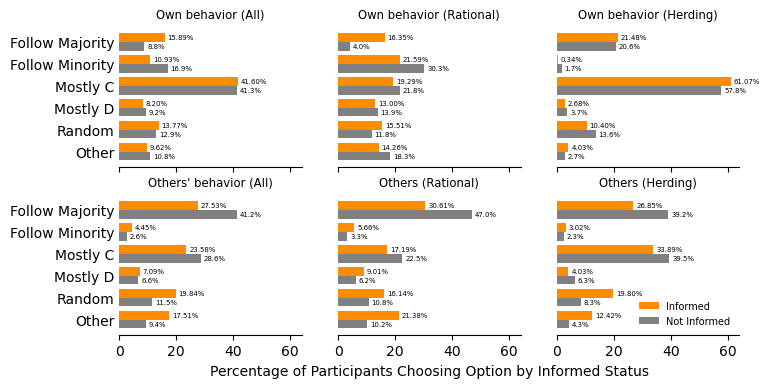

In [107]:
# create a 3 x 2 plot of the evolution of the herding model
fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

with plt.style.context(["science", "nature", "no-latex"]):
    plot_beliefs_by_informed_status_ASD(panel_df, 'debrief_self', show_y_labels=True, ax=ax[0][0])
    ax[0][0].set_title('Own behavior (All)')
    
    plot_beliefs_by_informed_status_ASD(panel_df.query("rel_classification == 'rational'"), 'debrief_self', show_y_labels=True, ax=ax[0][1])
    ax[0][1].set_title('Own behavior (Rational)')
    
    plot_beliefs_by_informed_status_ASD(panel_df.query("rel_classification == 'herding'"), 'debrief_self', show_y_labels=True, ax=ax[0][2])
    ax[0][2].set_title('Own behavior (Herding)')


    plot_beliefs_by_informed_status_ASD(panel_df, 'debrief_other', show_y_labels=True, ax=ax[1][0])
    ax[1][0].set_title('Others\' behavior (All)')
    # ax[1][0].set_xlabel('%Informed - %Not Informed')
    
    plot_beliefs_by_informed_status_ASD(panel_df.query("rel_classification == 'rational'"), 'debrief_other', show_y_labels=True, ax=ax[1][1])
    ax[1][1].set_title('Others (Rational)')
    ax[1][1].set_xlabel("Percentage of Participants Choosing Option by Informed Status")
    
    plot_beliefs_by_informed_status_ASD(panel_df.query("rel_classification == 'herding'"), 'debrief_other', show_y_labels=True, ax=ax[1][2])
    ax[1][2].set_title('Others (Herding)')
    ax[1][2].legend()

plt.savefig('../reports/figures/believe_shift_all_breakdown.pdf', bbox_inches='tight')
# plt.tight_layout()
plt.show()